# Simulating heart rate and response data

We can specify the expected effect of psilocybin on model parameters here and simulate data accordingly.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, halfnorm, expon, exponnorm, gamma
from ipywidgets import widgets
from IPython.display import display
from pymc3 import math
import pandas as pd
import arviz as az
import pymc3 as pm

## Simulation functions

Below, some simulation functions are defined that can simulate data from the HRD task used in Legrand et al., 2022.

In [2]:
def simulate_HRD_direct(alpha_mean, alpha_std, beta_lam, beta_loc, beta_scale, alpha_range=None,
                        sample = False, plot = False, beta_prior = 'gamma', n_trials = 50, ax = None):
    
    """
    simulates answers to HRD task directly based on distributions or single values of alpha and beta 
    for a range of d alphas (deltaBPMs).
    
    means and std define the distribution sampled from. If sample = False, then means are taken directly. 
    
    also works if supplied with a vector over trials to specify n_trials, as such:
    
    rand_array = np.random.randint(0, 10, 163)
    answers = simulate_HRD_direct(**sober_intero, n_trials = rand_array)
    """
    
    if alpha_range is None:
        alpha_range = np.arange(-40.5, 41, .5)
    
    if sample is True:
        # pick an alpha and beta from dists
        alpha = np.random.normal(loc=alpha_mean, scale=alpha_std) #size=(n_boot, len(alpha_range)))
        #beta = np.random.normal(loc=beta_mean, scale=beta_std) #size=(n_boot, len(alpha_range)))
        #beta = halfnorm(0, beta_std).rvs(size = 1)
        
        if beta_prior == 'exponnorm':
            beta = exponnorm(K = 1/(beta_scale*beta_lam), loc = beta_loc, scale = beta_scale).rvs(size = 1)
            # make sure beta is greater than 0
            if beta <= 0:
                beta = .01
            
        elif beta_prior == 'expon':
            # expon or half gaussian?
            beta = expon(loc = beta_loc, scale = 1/beta_lam).rvs(size = 1)
        
                    
        elif beta_prior == 'gamma':
            # gamma
            beta = gamma(a = beta_lam, loc = beta_loc, scale = beta_scale).rvs(size = 1)

        
    else:
        # or pick them directly
        alpha = alpha_mean
        
        if beta_prior == 'gamma':
            beta = beta_lam
        else:
            beta = beta_loc
    
    #print(alpha_range)
    # put through cumulative normal
    cumnor = norm.cdf(alpha_range, alpha, beta)
    #print(cumnor)
    # give answer (put through Binomial)
    try:
        # check wether int or array was given as n_trials
        iter(n_trials)
    except TypeError:
        # if int is specified as n_trials
        answers = np.random.binomial(np.array([n_trials]*len(cumnor)), cumnor)
    else:
        # if array is specified as n_trials
        answers = np.random.binomial(n_trials, cumnor)

    
    if plot:
        if ax is None:
            plt.plot(alpha_range, answers)
            plt.xlabel('Intensity ($\Delta$ BPM)')
            plt.ylabel('Number of answer = \'More\'')
            plt.show()
        
        else: 
            ax.plot(alpha_range, answers)
            ax.xlabel('Intensity ($\Delta$ BPM)')
            ax.ylabel('Number of answer = \'More\'')
        
        return answers
    
    """
    alpha = pm.Uniform("alpha", lower=-40.5, upper=40.5)
    beta = pm.HalfNormal("beta", 10)
    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(xij, alpha, beta)
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=nij, observed=rij)
    trace = pm.sample(
        chains=4, cores=4, tune=2000, draws=4000, return_inferencedata=True
    )"""

    return answers

def plot_HRD(alpha_mean, alpha_std, beta_lam, beta_loc, beta_scale):
    """quick function for plotting with widget"""
    
    simulate_HRD_direct(alpha_mean, alpha_std, beta_lam, beta_loc, beta_scale, plot = True)
    return


def simulate_many_HRD_direct(alpha_mean, alpha_std, beta_loc, beta_scale, beta_lam, alpha_range=None, N=100,
                             plot = True, plot_priors = True, only_plot = False, beta_prior = 'gamma',
                             n_trials = 50):
    """calls simulate_HRD_directly multiple times to produce answers accross experiment or population
        - make it return all that the above functions return
    """
    
    if alpha_range is None:
        alpha_range = np.arange(-40.5, 41, .5)
        
    result = np.zeros((N, len(alpha_range)))
    
    for i in range(N):
        result[i] = simulate_HRD_direct(alpha_mean=alpha_mean, alpha_std=alpha_std, 
                                        beta_loc=beta_loc, beta_scale=beta_scale, beta_lam = beta_lam,
                                        alpha_range=alpha_range, sample = True, plot = False,
                                        beta_prior = beta_prior, n_trials = n_trials)
    if plot is True:
        
        fig, ax1 = plt.subplots() 
                    
        ax1.plot(alpha_range, result[:min(50, N),:].T, color = 'grey', alpha = .2)
        
        # small hack to only have 1 label in legend
        ax1.plot(alpha_range, result[-1,:].T, color = 'grey', alpha = .2, label = "predictive prior sim")
        ax1.set_xlim(min(alpha_range), max(alpha_range))
        ax1.set_ylim(-.05, np.max(result))
        
        ax2 = ax1.twinx()
        #ax2.set_ylim(-0.01, .3)
        if plot_priors == True:
            ax2.plot(alpha_range, norm(alpha_mean, alpha_std).pdf(alpha_range), label = "alpha_prior")
            if beta_prior == 'exponnorm':  
                ax2.plot(alpha_range, exponnorm(beta_loc, beta_scale, beta_lam).pdf(alpha_range), label = "beta_prior")
            
            elif beta_prior == 'expon':
                ax2.plot(alpha_range, expon(loc = beta_loc, scale = 1/beta_lam).pdf(alpha_range), label = "beta_prior")

            elif beta_prior == 'gamma':
                ax2.plot(alpha_range, gamma(a = beta_lam, loc = beta_loc, scale = beta_scale).pdf(alpha_range), label = "beta_prior")
        
        ax1.set_xlabel('Intensity ($\Delta$ BPM)')
        ax1.set_ylabel('Number of answer = \'More\'')
        ax2.set_ylabel('P(X)')
        

        plt.show()
        
        if only_plot is True:
            return
        
        return result, fig
    
    return result

def plot_many_HRD(alpha_mean, alpha_std, beta_loc, beta_scale, beta_lam):
    """quick function for plotting with widget"""
    
    simulate_many_HRD_direct(alpha_mean, alpha_std, beta_loc, beta_scale, beta_lam, plot = True, only_plot = True)
    return

## Showing off the simulations

By changing the model parameters here, we can observe the effect it has on individual psychophysical functions.

In [3]:
# single subject
widgets.interact(plot_HRD, alpha_mean=(0, 30), alpha_std=(0, 10),
                 beta_loc=(0), beta_scale=(1), beta_lam = (0.1, 30))

interactive(children=(IntSlider(value=15, description='alpha_mean', max=30), IntSlider(value=5, description='a…

<function __main__.plot_HRD(alpha_mean, alpha_std, beta_lam, beta_loc, beta_scale)>

In [4]:
# many subjects
widgets.interact(plot_many_HRD, alpha_mean=(-40, 40), alpha_std=(0, 30),
                 beta_loc=(0), beta_scale=(1), beta_lam = (0.1, 30))

interactive(children=(IntSlider(value=0, description='alpha_mean', max=40, min=-40), IntSlider(value=15, descr…

<function __main__.plot_many_HRD(alpha_mean, alpha_std, beta_loc, beta_scale, beta_lam)>

In [6]:
# Gamma prior
def plot_gamma(loc, scale, lamb):
    x = np.arange(-5.5, 100, .5)
    plt.plot(x, gamma.pdf(x, lamb, loc, scale))
    plt.ylim(0, 0.3)
    
widgets.interact(plot_gamma, loc=0, scale=1, lamb = (0.0,100.0))

interactive(children=(IntSlider(value=0, description='loc', max=1), IntSlider(value=1, description='scale', ma…

<function __main__.plot_gamma(loc, scale, lamb)>

## Simulate some psilocybin conditions
This is where we can specify the parameters for specific psilocybin conditions

### Data from Legrand

#### Threshold
- Session 1: meanIntero = −6.97, CI95% [−8.59, −5.37], meanExtero = 1.36, CI95% [0.9, 1.85], t(205) = −9.89, p < 0.001, BF10 = 1.15e+ 16, d = −0.93
- Session 2: meanIntero = −8.50, 95% CI95% [−10.09, −6.91], meanExtero = 0.008, 95% CI [−0.48, 0.50], t(190) = −11.15, p < 0.001, BF10 = 2.85e+ 19, d = −1.03

#### Slope
- Session 1: meanIntero = 15.34, CI95% [14.39, 16.36], meanExtero = 9.58, CI95% [8.89, 10.39], t(205) = 9.05, p < 0.001, BF10 = 4.97e+ 13, d = −0.88
- Session 2: meanIntero = 11.96, 95% CI [11.17, 12.76], meanExtero = 8.69, 95% CI [8.11, 9.26], t(190) = 7.29, p < 0.001, BF10 = 9.12e+ 08, d = 0.67

also, Interaction session x slope => We have to control for session

### Psilo parameters

In [5]:
# for now, psilo has lower thresholds and steeper slopes

sober_intero = {
    'alpha_mean': -8.5,
    'alpha_std': 10,
    'beta_lam': 15.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

psi_5_intero = {
    'alpha_mean': -7.5,
    'alpha_std': 10,
    'beta_lam': 12.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

psi_10_intero = {
    'alpha_mean': -5.5,
    'alpha_std': 10,
    'beta_lam': 10.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

psi_15_intero = {
    'alpha_mean': -3.5,
    'alpha_std': 10,
    'beta_lam': 7.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

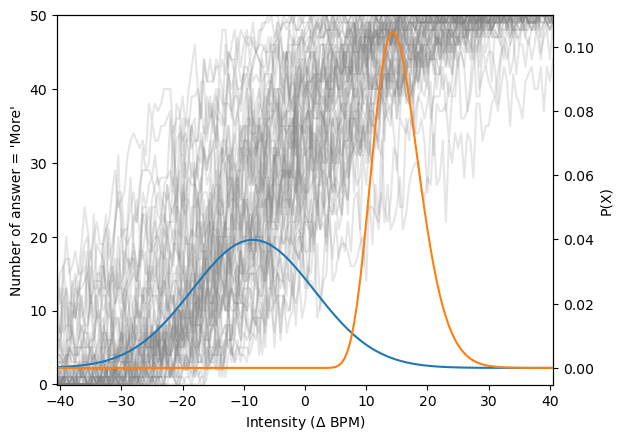

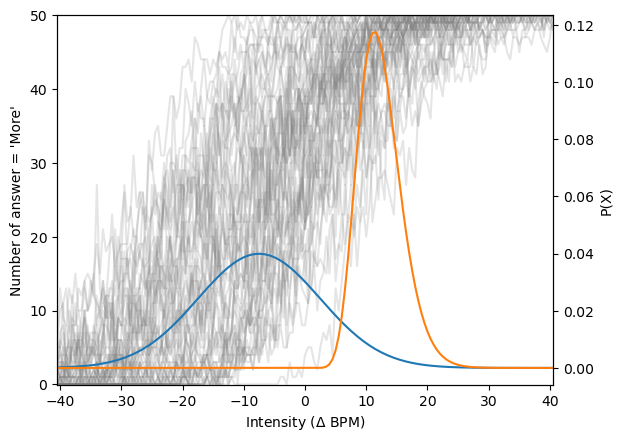

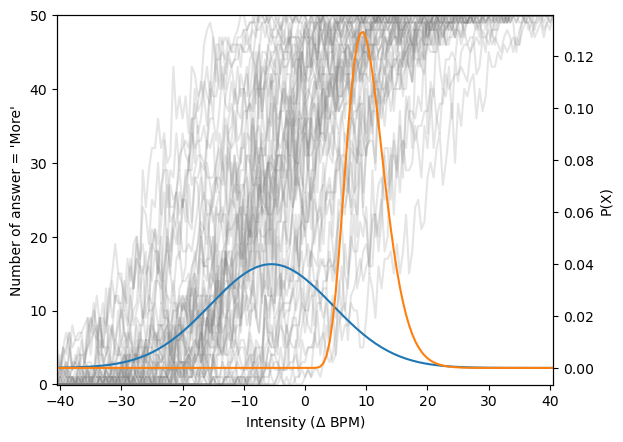

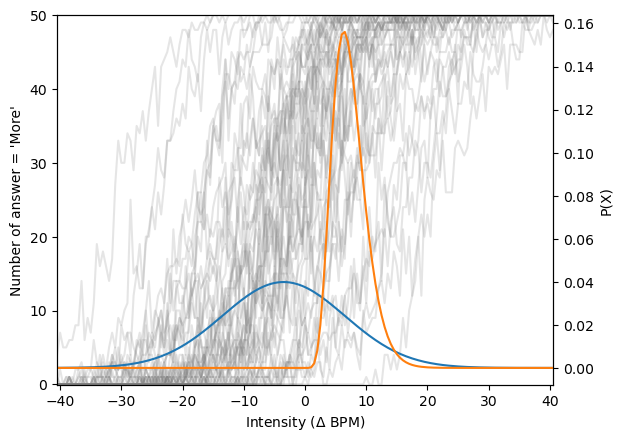

(array([[ 0.,  0.,  0., ..., 50., 50., 50.],
        [ 0.,  0.,  0., ..., 50., 50., 50.],
        [ 0.,  0.,  0., ..., 50., 50., 50.],
        ...,
        [ 0.,  0.,  0., ..., 50., 50., 50.],
        [ 0.,  0.,  0., ..., 50., 50., 50.],
        [ 0.,  0.,  0., ..., 50., 50., 50.]]),
 <Figure size 640x480 with 2 Axes>)

In [6]:
simulate_many_HRD_direct(**sober_intero)
simulate_many_HRD_direct(**psi_5_intero)
simulate_many_HRD_direct(**psi_10_intero)
simulate_many_HRD_direct(**psi_15_intero)

# Bayesian modelling
Here, we will use the Bayesian model supplied by Legrand to recover the simulation parameters.

<img src="https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/hierarchicalPsychophysics.png" align = 'left' alt="drawing" width="300"/>

$$ r_{i} \sim \mathcal{Binomial}(\theta_{i},n_{i})$$
$$ \Phi_{i, j}(x_{i, j}, \alpha, \beta) = \frac{1}{2} + \frac{1}{2} * erf(\frac{x_{i, j} - \alpha}{\beta * \sqrt{2}})$$
$$ \alpha_{i} \sim \mathcal{Normal}(\mu_{\alpha}, \sigma_{\alpha})$$
$$ \beta_{i} \sim \mathcal{Normal}(\mu_{\beta}, \sigma_{\beta})$$

$$ \mu_{\alpha} \sim  \mathcal{Uniform}(-50, 50)$$
$$ \sigma_{\alpha} \sim  |\mathcal{Normal}(0, 100)|$$

$$ \mu_{\beta} \sim  \mathcal{Uniform}(0, 100)$$
$$ \sigma_{\beta} \sim  |\mathcal{Normal}(0, 100)|$$


Where $erf$ is the [error function](https://en.wikipedia.org/wiki/Error_function), and $\Phi$ is the cumulative normal function with threshold $\alpha$ and slope $\beta$.



## Using simulate_(many_)HRD_direct

In [7]:
def cumulative_normal(x, alpha, beta):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * math.erf((x - alpha) / (beta * np.sqrt(2)))

### Single-Subject

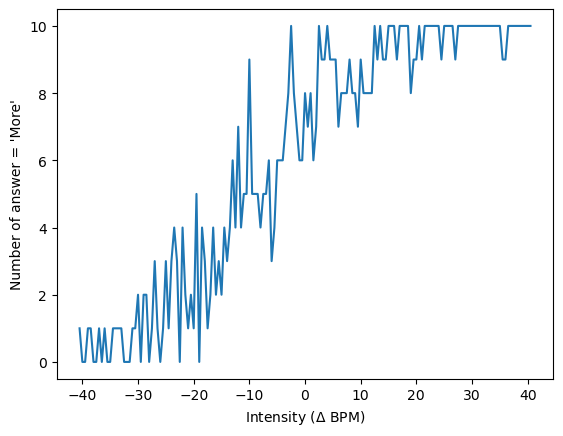

In [76]:
n_trials = 10 # trials per alpha condition
x = np.arange(-40.5, 41, 0.5)
n = np.array([n_trials] * len(x))
r = simulate_HRD_direct(**sober_intero, n_trials = 10, plot = True)
#rs = simulate_many_HRD_direct(**sober_intero, n_trials = 10)
## TODO adapt to Group level model, see other notebook

# remove no responses trials
validmask = n != 0
xij, nij, rij = x[validmask], n[validmask], r[validmask]

In [67]:
with pm.Model():

    alpha = pm.Uniform("alpha", lower=-40.5, upper=40.5)
    beta = pm.HalfNormal("beta", 10)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(xij, alpha, beta)
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=nij, observed=rij)
    trace = pm.sample(
        chains=4, cores=4, tune=2000, draws=4000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 4 seconds.


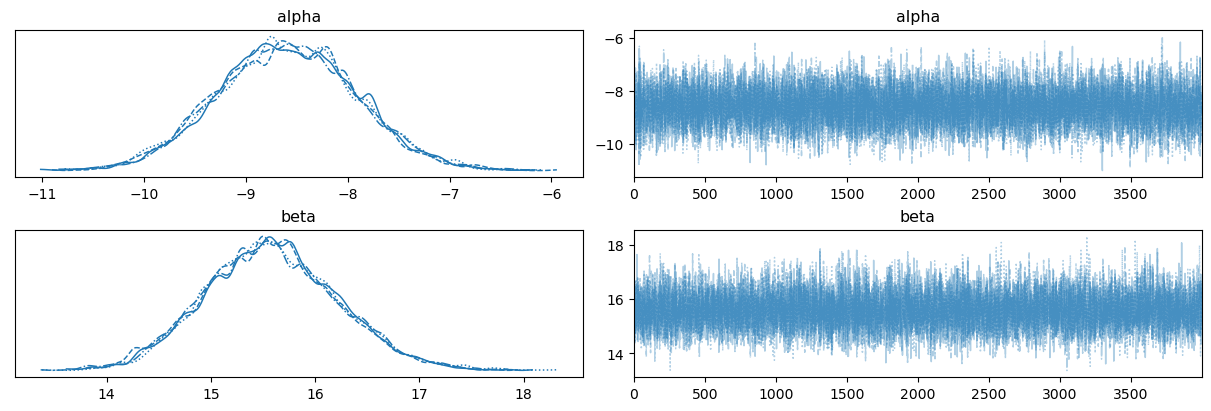

In [68]:
with pm.Model():
    az.plot_trace(trace, var_names=['alpha', 'beta'])

### Group-level


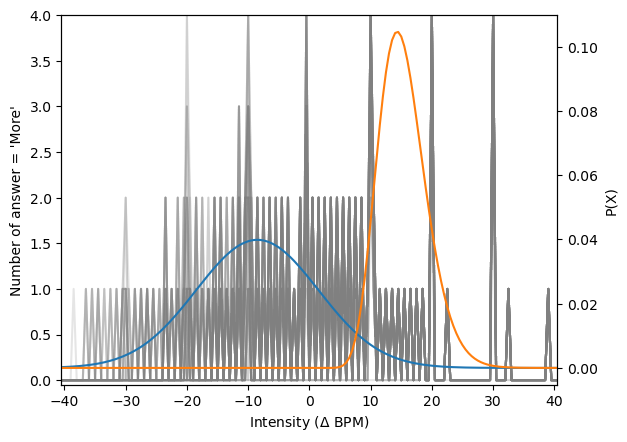

In [8]:
n_subs = 40 
# 'realistic trials': mean distribution of 120 trials derived form real-world data
n = np.array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 4., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       3., 0., 1., 0., 2., 0., 2., 4., 2., 0., 2., 0., 2., 0., 2., 0., 2.,
       0., 2., 0., 2., 0., 2., 0., 3., 0., 2., 4., 2., 0., 2., 0., 2., 0.,
       2., 0., 2., 0., 2., 0., 2., 0., 1., 0., 2., 0., 4., 0., 2., 0., 2.,
       0., 2., 0., 2., 0., 2., 0., 2., 0., 2., 0., 2., 0., 2., 0., 1., 4.,
       2., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]).astype(int)
n_trials = n
# uncomment for uniform trials
#n_trials = 10 # trials per alpha condition 
#n = np.array([n_trials] * len(x)) 
x = np.arange(-40.5, 41, 0.5)
rs, _ = simulate_many_HRD_direct(**sober_intero, n_trials = n_trials, N = n_subs)

# total vectors are flat
r_total = rs.flatten()#.tolist()
x_total = np.tile(x, n_subs)#.tolist()
#n_total = n.repeat(n_subs)#.tolist() # uncommment uniform trials
n_total = np.tile(n, n_subs)#.tolist()


sub_total = np.array([[i] * len(x) for i in range(n_subs)]).flatten()#.tolist()
# remove no responses trials
validmask = n_total != 0
# mask the totals to remove 0s
x_total, n_total, r_total, sub_total = x_total[validmask], n_total[validmask], r_total[validmask], sub_total[validmask]

In [9]:
trial_type = "realistic" #"uniform"

## plotting the individual answers in navigatable widget in same style as Legrand
def plot_responses(i):
    
    # plotting code from legrand
    fig, axs = plt.subplots(figsize=(8, 5))
    
    # loop over each intensity
    #for j in rane(len(x)):
    #print(len(x[n != 0])) 
    #print(len(rij[sij == i])) 

    if trial_type == 'realistic':
        #axs.plot(x[n != 0], rij[sij == i]/nij[sij == i],
        #             'o', alpha=0.5, color='#4c72b0', markeredgecolor='k', markersize=nij[sij == i]*5)

        for j, point in enumerate(r_total[sub_total == i]/n_total[sub_total == i]):
            axs.plot(x[n != 0][j], point,
                     'o', alpha=0.5, color='#4c72b0', markeredgecolor='k', markersize=n_total[sub_total == i][j]*5)
    
    elif trial_type == 'uniform':
        axs.plot(x, rs[i]/n_trials,
                 'o', alpha=0.5, color='#4c72b0', markeredgecolor='k', markersize = 5)#markersize=n_trials*5)

    plt.ylabel('P$_{(Response = More|Intensity)}$')
    plt.xlabel('Intensity ($\Delta$ BPM)')
    plt.tight_layout()
    #sns.despine()

widgets.interact(plot_responses, i=(0, n_subs-1))

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_responses(i)>

In [10]:
with pm.Model() as hierarchicalPsychophysics:

    mu_alpha = pm.Uniform("mu_alpha", lower=-50, upper=50)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=100)

    mu_beta = pm.Uniform("mu_beta", lower=0, upper=100)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=100)

    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=n_subs)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=n_subs)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(x_total, alpha[sub_total], beta[sub_total])
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=r_total)

In [11]:
with hierarchicalPsychophysics:

    trace = pm.sample(
        chains=4, cores=4, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


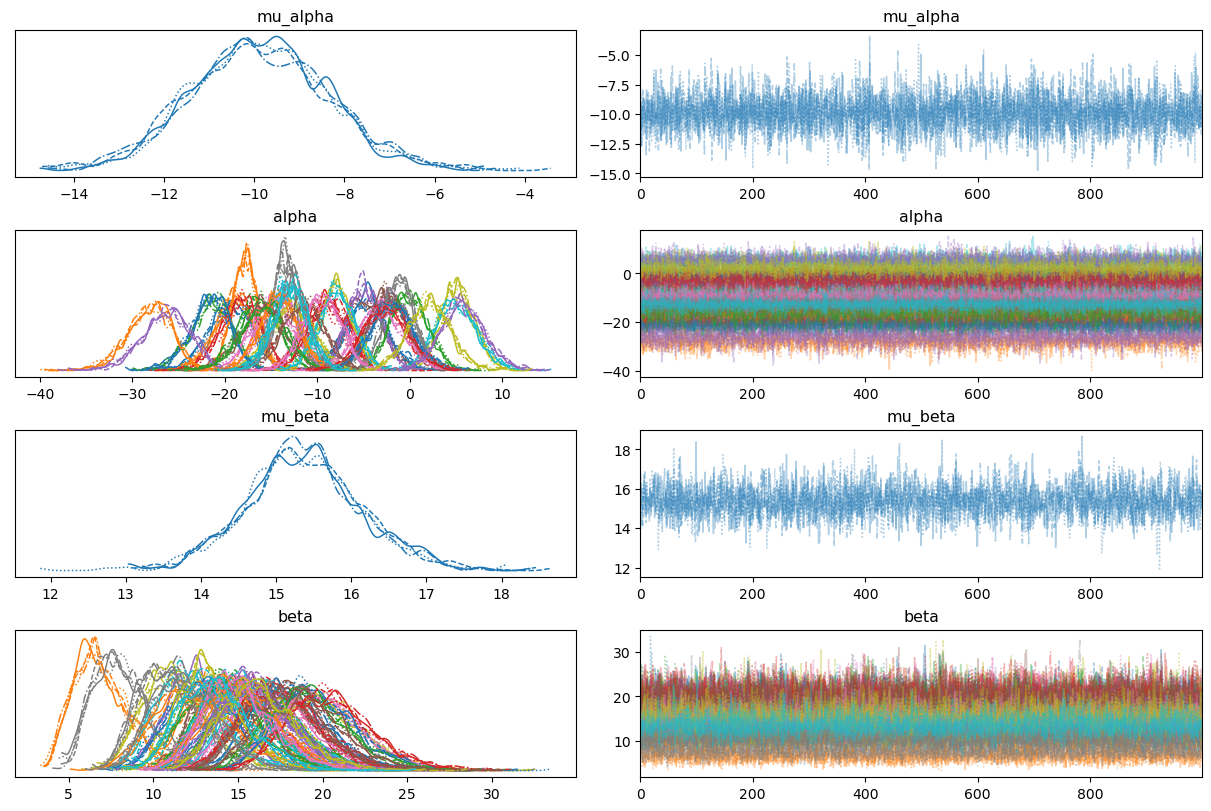

In [14]:
traceplot = az.plot_trace(trace, var_names=["mu_alpha", "alpha", 'mu_beta', 'beta'])

In [12]:
stats = az.summary(trace, var_names=["mu_alpha", "mu_beta", 'sigma_alpha', 'sigma_beta'])
stats

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha     -9.181  1.682 -12.441   -6.090      0.023    0.017    5289.0   
mu_beta      15.526  0.763  14.078   16.945      0.015    0.011    2466.0   
sigma_alpha  10.284  1.279   7.989   12.692      0.021    0.015    3641.0   
sigma_beta    3.831  0.682   2.516    5.049      0.016    0.012    1732.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha     4794.0    5385.0    2873.0    1.0  
mu_beta      2466.0    2458.0    2692.0    1.0  
sigma_alpha  3526.0    3767.0    3280.0    1.0  
sigma_beta   1729.0    1753.0    2399.0    1.0

#### Posterior predictive checks

In [15]:
trace.posterior

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1000, alpha_dim_0: 40, beta_dim_0: 40,
                    thetaij_dim_0: 2640)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * alpha_dim_0    (alpha_dim_0) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
  * beta_dim_0     (beta_dim_0) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
  * thetaij_dim_0  (thetaij_dim_0) int64 0 1 2 3 4 ... 2635 2636 2637 2638 2639
Data variables:
    alpha          (chain, draw, alpha_dim_0) float64 -16.79 -17.71 ... -10.9
    beta           (chain, draw, beta_dim_0) float64 12.73 11.83 ... 14.48 11.79
    mu_alpha       (chain, draw) float64 -7.823 -12.67 -9.008 ... -10.74 -8.116
    sigma_alpha    (chain, draw) float64 9.368 8.885 9.291 ... 10.03 8.666 9.582
    mu_beta        (chain, draw) float64 15.3 16.31 15.75 ... 16.26 15.03 15.57
    sigma_beta     (chain, draw) float64 4.406 4.603 3.115 ... 3.869 3.342 3.666
    thetaij        (chain, draw, thetaij_dim_0) float64 0.04409 0.06081 ... 1.0
Attributes:
    created_at:                 2022-09-14T06:43:26.172775
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.11.1
    sampling_time:              12.001853466033936
    tuning_steps:               1000

In [21]:
hierarchicalPsychophysics

In [22]:
with hierarchicalPsychophysics:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["mu_alpha", "mu_beta", 'sigma_alpha', 'sigma_beta', 'rij']
    )

In [24]:
def posterior_cumulative_gauss(ppc):
    
    shape = 

    np.vstack((ppc['mu_alpha'], ppc['mu_beta'])).shape

    ppc['sigma_alpha']
    ppc['simga_beta']
    

{'mu_alpha': array([ -7.82330869, -12.66955762,  -9.00845471, ...,  -7.96715991,
        -10.74236053,  -8.11637269]),
 'mu_beta': array([15.30364173, 16.31022519, 15.75078625, ..., 16.25646009,
        15.0316017 , 15.56898095]),
 'sigma_alpha': array([ 9.36830059,  8.8852392 ,  9.29059075, ..., 10.03240129,
         8.6662879 ,  9.58230907]),
 'sigma_beta': array([4.40638529, 4.60279138, 3.1145886 , ..., 3.86935242, 3.3416377 ,
        3.66604479]),
 'rij': array([[0, 0, 0, ..., 4, 1, 1],
        [0, 0, 1, ..., 4, 1, 1],
        [0, 0, 0, ..., 4, 1, 1],
        ...,
        [0, 0, 0, ..., 4, 1, 1],
        [0, 0, 0, ..., 4, 1, 1],
        [0, 1, 1, ..., 4, 1, 1]])}

In [29]:
for key, item in ppc.items():
    print(item.shape)
    
np.vstack((ppc['mu_alpha'], ppc['mu_beta'])).shape

(4000,)
(4000,)
(4000,)
(4000,)
(4000, 2640)


(2, 4000)

#### running all conditions

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_placebo, alpha_placebo, sigma_beta, mu_beta_placebo, sigma_alpha, mu_alpha_placebo]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_alpha_placebo -10.264  1.560 -13.235   -7.415      0.021    0.015   
mu_beta_placebo   15.269  0.699  13.970   16.550      0.014    0.010   
sigma_alpha        9.653  1.233   7.416   11.929      0.020    0.015   
sigma_beta         3.372  0.648   2.193    4.586      0.017    0.012   

                  ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha_placebo    5463.0  5323.0    5478.0    3068.0    1.0  
mu_beta_placebo     2565.0  2551.0    2583.0    2699.0    1.0  
sigma_alpha         3684.0  3550.0    3827.0    2890.0    1.0  
sigma_beta          1401.0  1401.0    1366.0    1659.0    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_5 mg psilo, alpha_5 mg psilo, sigma_beta, mu_beta_5 mg psilo, sigma_alpha, mu_alpha_5 mg psilo]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_alpha_5 mg psilo  -6.420  1.509  -9.354   -3.645      0.021    0.015   
mu_beta_5 mg psilo   13.317  0.859  11.743   14.898      0.014    0.010   
sigma_alpha           9.338  1.180   7.272   11.654      0.017    0.013   
sigma_beta            4.665  0.723   3.361    6.030      0.015    0.010   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha_5 mg psilo    5200.0  5021.0    5180.0    3027.0    1.0  
mu_beta_5 mg psilo     3566.0  3520.0    3625.0    2826.0    1.0  
sigma_alpha            4605.0  4413.0    4717.0    2899.0    1.0  
sigma_beta             2379.0  2372.0    2396.0    2638.0    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_10 mg psilo, alpha_10 mg psilo, sigma_beta, mu_beta_10 mg psilo, sigma_alpha, mu_alpha_10 mg psilo]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


                        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_alpha_10 mg psilo  -4.541  1.768  -7.777   -1.245      0.025    0.019   
mu_beta_10 mg psilo    9.948  0.693   8.640   11.219      0.012    0.009   
sigma_alpha           10.695  1.330   8.276   13.148      0.019    0.014   
sigma_beta             3.921  0.593   2.933    5.078      0.013    0.009   

                      ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha_10 mg psilo    4882.0  4395.0    4909.0    2644.0    1.0  
mu_beta_10 mg psilo     3261.0  3261.0    3247.0    3119.0    1.0  
sigma_alpha             4714.0  4363.0    5077.0    2782.0    1.0  
sigma_beta              2190.0  2152.0    2286.0    2635.0    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_15 mg psilo, alpha_15 mg psilo, sigma_beta, mu_beta_15 mg psilo, sigma_alpha, mu_alpha_15 mg psilo]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_alpha_15 mg psilo -1.451  1.511  -4.362    1.405      0.027    0.025   
mu_beta_15 mg psilo   6.178  0.457   5.290    6.995      0.009    0.006   
sigma_alpha           9.220  1.152   7.192   11.446      0.021    0.016   
sigma_beta            2.634  0.380   1.915    3.334      0.008    0.006   

                      ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha_15 mg psilo    3029.0  1880.0    3075.0    2186.0    1.0  
mu_beta_15 mg psilo     2514.0  2514.0    2491.0    2350.0    1.0  
sigma_alpha             2894.0  2728.0    3107.0    2358.0    1.0  
sigma_beta              2334.0  2319.0    2348.0    2515.0    1.0  


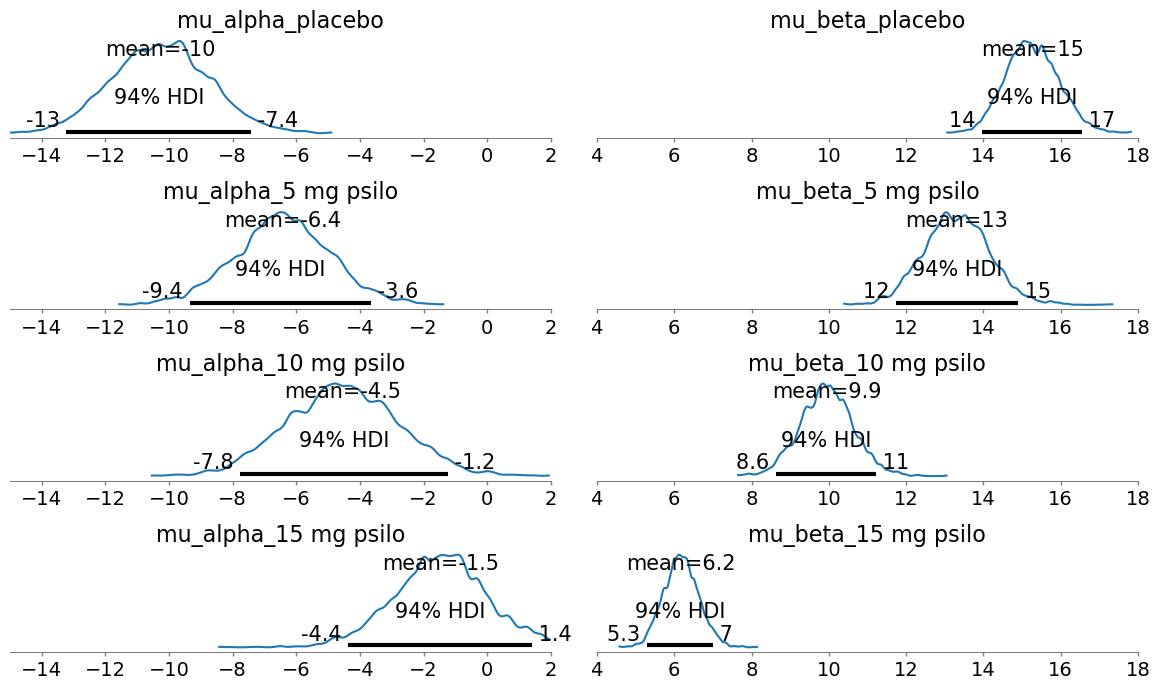

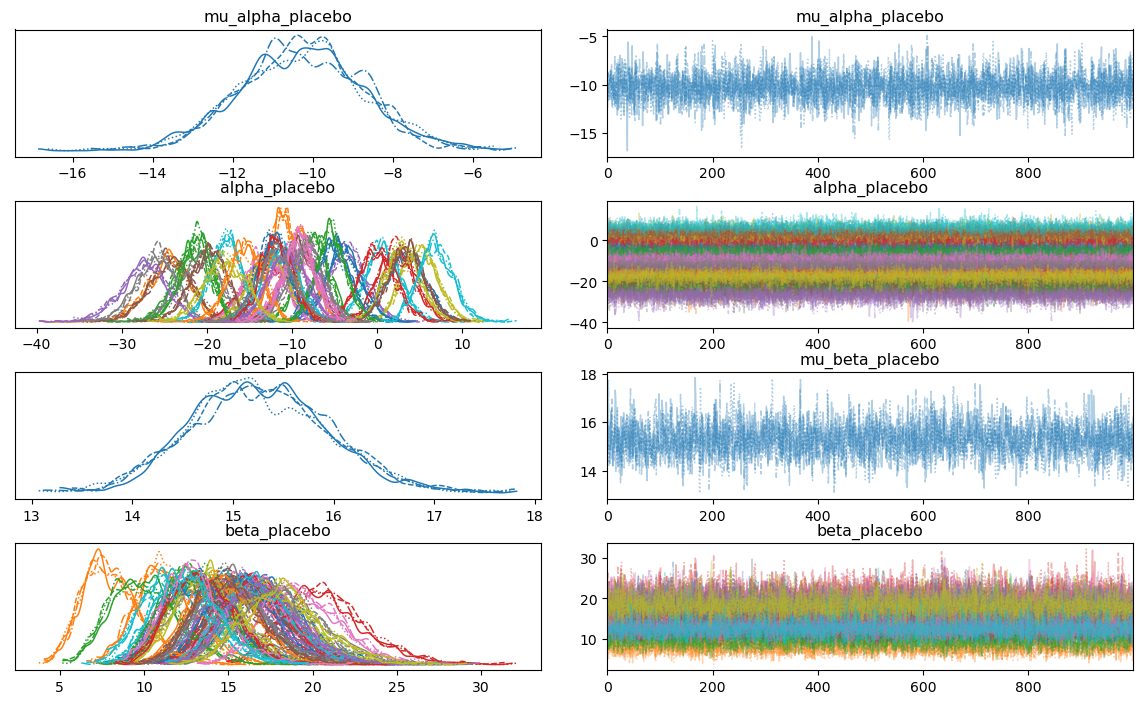

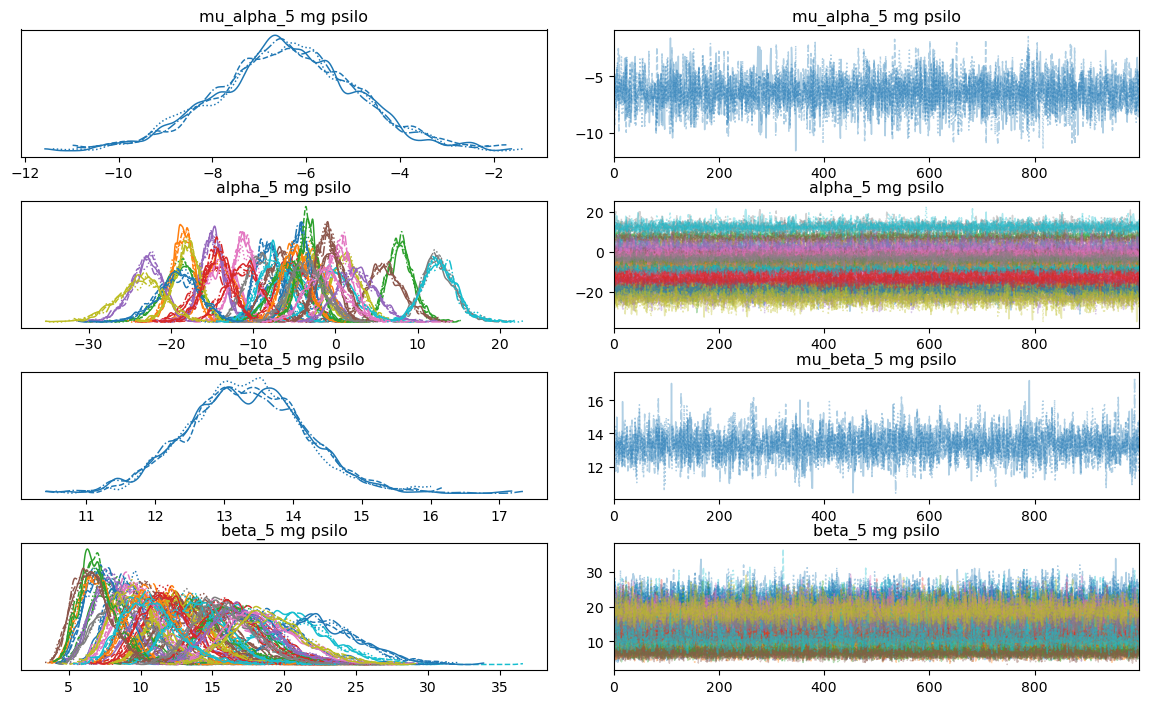

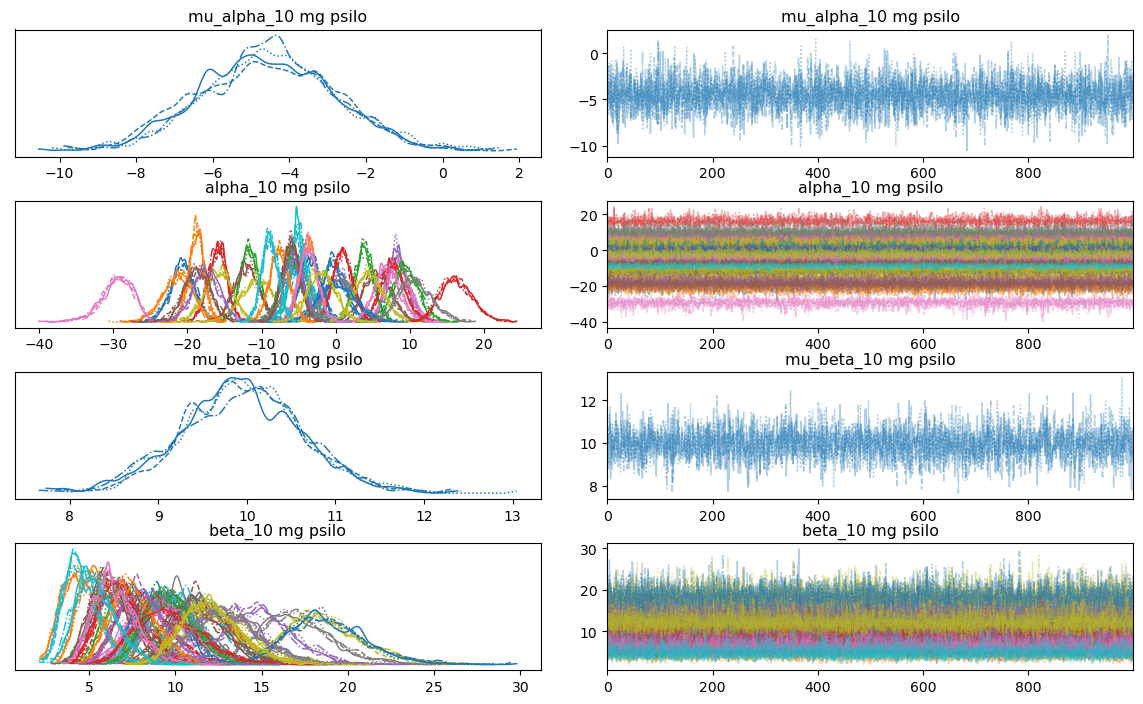

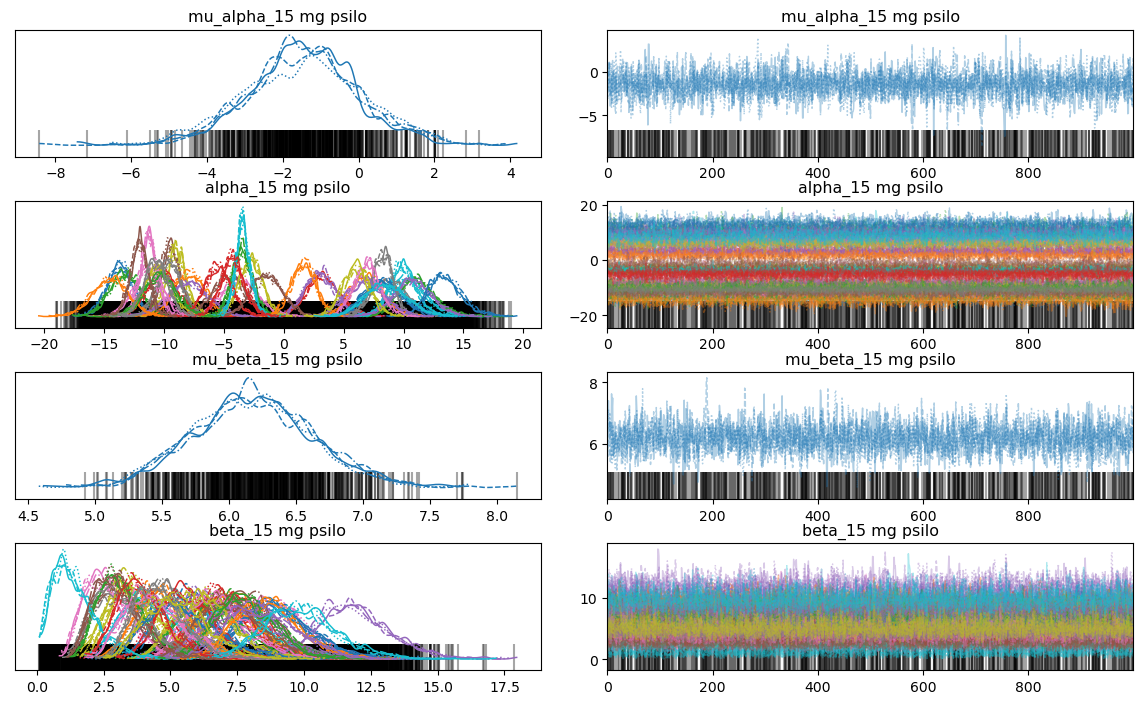

In [57]:
def run_hierarchical(conditions, condition_names = ['placebo', '5 mg psilo', '10 mg psilo', '15 mg psilo'],
                     trials = 'realistic', n_subs = 40):
    """
    runs the hierarchical model above for all conditions supplied in iterable conditions
    if running only condition, please supply it as a list with one element [condition]
    
    trials can be either int of n_trials for each \delta BPM or str 'realistic', which
    implements approximately realistic trial numbers
    """
    
    i = 0 # index for plots
    
    # psoterior figure
    postfig, postaxes = plt.subplots(4,2, figsize = (12, 7))
    
    for k, col in enumerate(postaxes.T):
        
        for ax in col:
            if k == 0:
                ax.set_xlim(-15, 2)
            if k == 1:
                ax.set_xlim(4, 18)
    
    for condition, name in zip(conditions, condition_names):
        
        ## decide on n_trials
        if trials == 'realistic':
                    
            # 'realistic trials': mean distribution of 120 trials derived form real-world data
            n = np.array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
               0., 1., 0., 1., 4., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
               3., 0., 1., 0., 2., 0., 2., 4., 2., 0., 2., 0., 2., 0., 2., 0., 2.,
               0., 2., 0., 2., 0., 2., 0., 3., 0., 2., 4., 2., 0., 2., 0., 2., 0.,
               2., 0., 2., 0., 2., 0., 2., 0., 1., 0., 2., 0., 4., 0., 2., 0., 2.,
               0., 2., 0., 2., 0., 2., 0., 2., 0., 2., 0., 2., 0., 2., 0., 1., 4.,
               2., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
               0., 0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]).astype(int)
        
            n_trials = n
            n_total = np.tile(n, n_subs)
            
        else:
            n_trials = trials
            n = np.array([n_trials] * len(x)) 
            n_total = n.repeat(n_subs)
        
        ## simulate
        
        # delta BPMs
        x = np.arange(-40.5, 41, 0.5)
        rs = simulate_many_HRD_direct(**condition, n_trials = n_trials, N = n_subs, plot = False)
                
        # total vectors are flat
        r_total = rs.flatten()
        x_total = np.tile(x, n_subs)

        sub_total = np.array([[i] * len(x) for i in range(n_subs)]).flatten()
        # remove no responses trials
        validmask = n_total != 0
        # mask the totals to remove 0s
        x_total, n_total, r_total, sub_total = x_total[validmask], n_total[validmask], r_total[validmask], sub_total[validmask]
        
        ## run model
        # setup
        with pm.Model() as hierarchicalPsychophysics:

            mu_alpha = pm.Uniform(f"mu_alpha_{name}", lower=-50, upper=50)
            sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=100)

            mu_beta = pm.Uniform(f'mu_beta_{name}', lower=0, upper=100)
            sigma_beta = pm.HalfNormal("sigma_beta", sigma=100)

            alpha = pm.Normal(f"alpha_{name}", mu=mu_alpha, sigma=sigma_alpha, shape=n_subs)
            beta = pm.Normal(f'beta_{name}', mu=mu_beta, sigma=sigma_beta, shape=n_subs)

            thetaij = pm.Deterministic(
                "thetaij", cumulative_normal(x_total, alpha[sub_total], beta[sub_total]))

            rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=r_total)
            
            # run
            trace = pm.sample(
                    chains=4, cores=4, return_inferencedata=True)
            
            ## TODO Continue here, figure out how to plot the posteriors
            
            # plot trace
            tracefig, traceaxes = plt.subplots(4,2, figsize = (12, 7))
            tracefig.tight_layout()
            traceplot = az.plot_trace(trace, var_names=[f"mu_alpha_{name}", f"alpha_{name}",
                                                        f'mu_beta_{name}', f'beta_{name}'], axes = traceaxes)

            # save traceplot
            #traceplot.savefig(f'simulation-results/trace_{name}', facecolor = 'w', transparent = False)
            tracefig.savefig(f'simulation-results/trace_{name}', facecolor = 'w', transparent = False)
            
            # save inference results
            stats = az.summary(trace, var_names=[f"mu_alpha_{name}", f"mu_beta_{name}", 
                                                 'sigma_alpha', 'sigma_beta'])
            stats.to_csv(f'simulation-results/stats{name}.csv', index = False)
            print(stats)
            
            # plot posterior
            #fig, axs = plt.subplots(ncols = 2, figsize = (12,1.5))
            az.plot_posterior(trace,var_names=[f"mu_alpha_{name}"], ax=postaxes[i, 0])
            az.plot_posterior(trace,var_names=[f"mu_beta_{name}"], ax=postaxes[i, 1])
            
            i += 1 # increase plot counter
            
    # save/plot inference on group level
    postfig.tight_layout()
    postfig.savefig(f'simulation-results/posterior_all', facecolor = 'w', transparent = False)

    return

conditions = [sober_intero, psi_5_intero, psi_10_intero, psi_15_intero]
run_hierarchical(conditions)

In [ ]:
sober_intero = {
    'alpha_mean': -8.5,
    'alpha_std': 10,
    'beta_lam': 15.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

psi_5_intero = {
    'alpha_mean': -7.5,
    'alpha_std': 10,
    'beta_lam': 12.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

psi_10_intero = {
    'alpha_mean': -5.5,
    'alpha_std': 10,
    'beta_lam': 10.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

psi_15_intero = {
    'alpha_mean': -3.5,
    'alpha_std': 10,
    'beta_lam': 7.34,
    'beta_loc': 0,
    'beta_scale': 1
    }

## Next modeling steps

do prior predictive checks
1. re-parameterize cumulative Gaussian to logit to improve upon the divergences
2. account for multiple measurements in the model
3. account for session effects
4. do posterior predictive checks

Make several hypotheses based on something, pit them against each other.

## Using simulate_HRD

In [25]:
# Setting up a dataframe with the same column names as in original

column_names = ['Decision', 'Alpha', 'listenBPM', 'responseBPM', 'ResponseCorrect']
this_df = pd.DataFrame({col:val for col, val in zip(column_names, simulate_HRD(60,5,70,20))})

We preprocess the data to extract the intensity $x$, the number or trials $n$ and number of hit responses $r$.


In [26]:
x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)

for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
    x[ii] = intensity
    n[ii] = sum(this_df.Alpha == intensity)
    r[ii] = sum((this_df.Alpha == intensity) & (this_df.Decision == True))

# remove no responses trials
validmask = n != 0
xij, nij, rij = x[validmask], n[validmask], r[validmask]

In [15]:
def cumulative_normal(x, alpha, beta):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * math.erf((x - alpha) / (beta * np.sqrt(2)))

In [28]:
with pm.Model():

    alpha = pm.Uniform("alpha", lower=-40.5, upper=40.5)
    beta = pm.HalfNormal("beta", 10)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(xij, alpha, beta)
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=nij, observed=rij)
    trace = pm.sample(
        chains=4, cores=4, tune=2000, draws=4000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 4 seconds.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

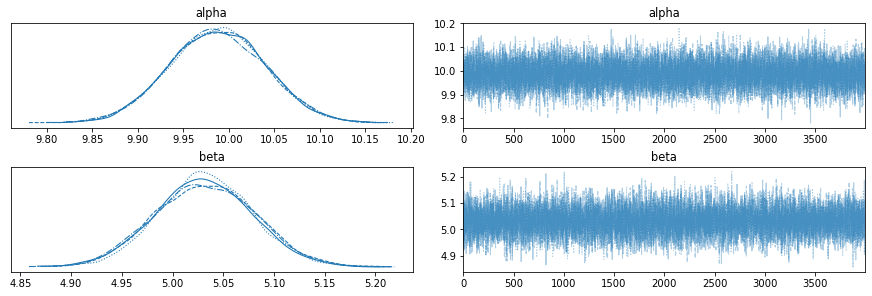

In [29]:
az.plot_trace(trace, var_names=['alpha', 'beta'])

In [31]:
widgets.interact(simulate_HRD, mean_BPM=(20, 120), std_BPM=(.001, 20), mean_belief=(20, 120),
                 std_belief=(.001, 20), n_boot = (1, 10000), only_plot = True)

interactive(children=(IntSlider(value=70, description='mean_BPM', max=120, min=20), FloatSlider(value=10.00049…

<function __main__.simulate_HRD(mean_BPM, std_BPM, mean_belief, std_belief, n_boot=500, min_alpha=-40.5, max_alpha=41, d_alpha=0.5, plot=False, only_plot=False)>

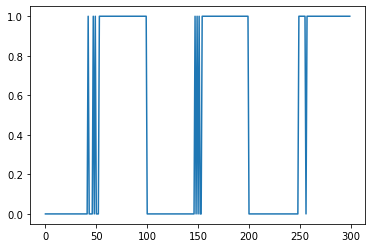

In [72]:
plt.plot(responses[:300])

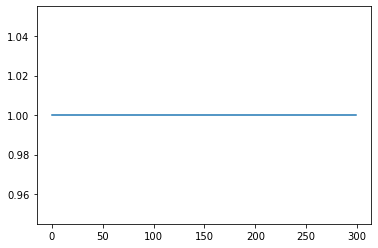

In [42]:
plt.plot((norm.cdf(listenBPM, loc=30, scale=10)>0.5)[:300])

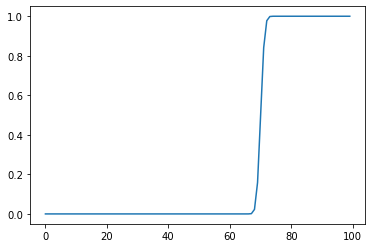

In [43]:
plt.plot(norm.cdf(np.arange(100), loc = 70, scale = 1))

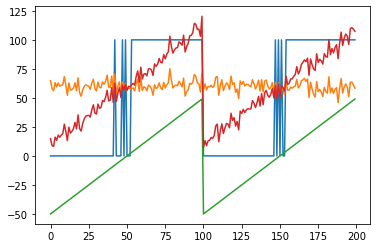

In [73]:
plt.plot(responses[:200]*100)
plt.plot(listenBPM[:200])
plt.plot(alphas[:200])
plt.plot(responseBPM[:200])

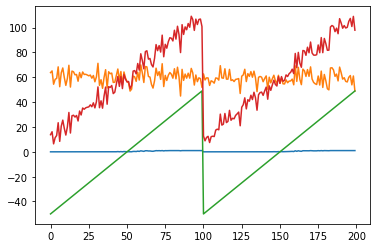

In [51]:
plt.plot(responses[:200])
plt.plot(hr[:200])
plt.plot(alphas[:200])
plt.plot(tones[:200])

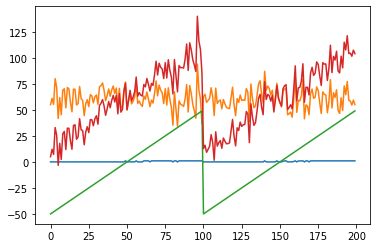

In [35]:
plt.plot(responses[:200])
plt.plot(hr[:200])
plt.plot(alphas[:200])
plt.plot(tones[:200])

In [93]:
import pymc3 as pm
import aesara.tensor as at

In [103]:
def cumulative_normal(x, alpha, beta):
    """Cumulative distribution function for the standard normal distribution"""
    return 0.5 + 0.5 * at.erf((x - alpha) / (beta * at.sqrt(2)))

In [27]:
with pm.Model():
    mu_heart_rate = pm.Uniform("mu_heart_rate", lower=20.0, upper=120.0)
    sigma_heart_rate = pm.Uniform("sigma_heart_rate", lower=.001, upper=30.0)
    heart_rate = pm.Normal("heart_rate", mu=mu_heart_rate, sigma=sigma_heart_rate, observed=hr)  


AttributeError: __enter__

In [26]:
    mu_alpha = pm.Uniform("mu_alpha", lower=-50.5, upper=50.5)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=100)

    mu_beta = pm.Uniform("mu_beta", lower=0, upper=100)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=100)

    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=nsubj)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(x_total, alpha[sub_total], beta[sub_total])
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=r_total)

ValueError: No value given for parent tau

In [ ]:
with semantic:
    trace_semantic = pm.sample(
        chains=2, cores=2, tune=1000, draws=1000, return_inferencedata=True
    )